# Final Spatio-Temporal AutoEncoder (rgb) Model Train - Test Script

## Flipped frames corrector code

In [ ]:
import os
import glob
import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image
from tqdm import tqdm # Progress bar

# ================= CONFIGURATION =================
# Path to the CORRUPTED testing videos
TEST_DATA_DIR = '/kaggle/input/pixel-play-26/Avenue_Corrupted-20251221T112159Z-3-001/Avenue_Corrupted/Dataset/testing_videos'

# Path where we will save the CLEANED videos
CLEAN_DATA_DIR = '/kaggle/working/cleaned_testing_videos'

MODEL_PATH = 'Final_models/rotnet_model.pth'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# =================================================

def clean_dataset():
    print(f"Processing on: {DEVICE}")
    
    # 1. Load the Trained RotNet
    model = models.resnet18(pretrained=False) # No need to download weights again
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2) # Matches our binary training
    
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model = model.to(DEVICE)
    model.eval()
    
    # Standard transform for the model input
    # Note: We do NOT augment here, just resize/norm
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # 2. Find all images
    # We walk through the directory to keep structure
    image_paths = sorted(glob.glob(os.path.join(TEST_DATA_DIR, '**', '*.jpg'), recursive=True))
    print(f"Found {len(image_paths)} frames to process.")
    
    # 3. Processing Loop
    flip_count = 0
    
    for img_path in tqdm(image_paths, desc="Cleaning"):
        # A. Setup paths
        # Get relative path (e.g., "01/frame_0001.jpg") to maintain structure
        rel_path = os.path.relpath(img_path, TEST_DATA_DIR)
        save_path = os.path.join(CLEAN_DATA_DIR, rel_path)
        
        # Create folder if not exists
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        
        # B. Predict Rotation
        image = Image.open(img_path).convert('RGB')
        input_tensor = preprocess(image).unsqueeze(0).to(DEVICE)
        
        with torch.no_grad():
            outputs = model(input_tensor)
            _, predicted = torch.max(outputs, 1)
            label = predicted.item()
            
        # C. Fix and Save
        # Label 0 = Upright (Keep as is)
        # Label 1 = Flipped (Needs 180 rotation to fix)
        
        if label == 1:
            # It was detected as Upside Down, so we rotate it -180 (or 180) to fix
            fixed_image = image.transpose(Image.FLIP_TOP_BOTTOM) 
            flip_count += 1
        else:
            fixed_image = image
            
        # Save the fixed image
        fixed_image.save(save_path)

    print("-" * 30)
    print("Cleaning Complete!")
    print(f"Total Images: {len(image_paths)}")
    print(f"Images Flipped/Fixed: {flip_count}")
    print(f"Cleaned dataset saved to: {CLEAN_DATA_DIR}")

if __name__ == "__main__":
    clean_dataset()

Processing on: cuda


KeyboardInterrupt: 

## Noise remover using FastDVDnet (test)

In [4]:
import os
import shutil
import glob
import re
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import sys

# ================= CONFIGURATION =================
# 1. WHERE ARE YOUR NOISY FRAMES?
# Adjust this to the root folder containing '01', '02', etc.
INPUT_ROOT = "/kaggle/working/cleaned_testing_videos" 

# 2. WHERE TO SAVE CLEAN FRAMES?
OUTPUT_ROOT = "/kaggle/working/denoised_dataset_test"

# 3. SETTINGS (The Winning Formula)
NOISE_SIGMA = 40 / 255.0  
BATCH_SIZE = 16
NUM_WORKERS = 4
# =================================================

# --- UTILS ---
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

def install_and_setup():
    if not os.path.exists("fastdvdnet"):
        print("🛠️ Cloning FastDVDnet...")
        os.system("git clone https://github.com/m-tassano/fastdvdnet.git")
        os.system("pip install tensorboardX")
    
    if not os.path.exists("fastdvdnet/model/model.pth"):
        os.makedirs("fastdvdnet/model", exist_ok=True)
        os.system("wget -O fastdvdnet/model/model.pth https://github.com/m-tassano/fastdvdnet/raw/master/model.pth")

# --- DATASET ---
class FrameSequenceDataset(Dataset):
    def __init__(self, frame_paths):
        self.frame_paths = frame_paths
        self.total = len(frame_paths)
        
    def __len__(self):
        return self.total
    
    def __getitem__(self, idx):
        # Sliding Window of 5 frames
        indices = [max(0, min(self.total - 1, idx + offset)) for offset in range(-2, 3)]
        
        frames = []
        for i in indices:
            path = self.frame_paths[i]
            img = cv2.imread(path)
            if img is None:
                img = np.zeros((360, 640, 3), dtype=np.uint8) # Fallback size
            
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.astype(np.float32) / 255.0
            frames.append(img)
            
        stack = np.concatenate(frames, axis=2) # (H, W, 15)
        tensor = torch.from_numpy(stack).permute(2, 0, 1) # (15, H, W)
        return tensor

# --- MAIN LOOP ---
def run_mass_cleaning():
    install_and_setup()
    
    # Import Model
    sys.path.append("fastdvdnet")
    try:
        from models import FastDVDnet
    except ImportError:
        from fastdvdnet.models import FastDVDnet

    # Find all video folders (01, 02, ... 21)
    video_folders = sorted(glob.glob(os.path.join(INPUT_ROOT, "*")))
    # Filter to ensure they are directories
    video_folders = [f for f in video_folders if os.path.isdir(f)]
    
    print(f"🌍 Found {len(video_folders)} videos to clean.")

    # Setup Model Once
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = FastDVDnet(num_input_frames=5)
    
    state_dict = torch.load("fastdvdnet/model/model.pth", map_location=device)
    new_state = {k.replace('module.', ''): v for k, v in state_dict.items()}
    model.load_state_dict(new_state)
    
    if torch.cuda.device_count() > 1:
        print(f"🔥 Dual GPU Active")
        model = nn.DataParallel(model)
        
    model.to(device)
    model.eval()

    # --- LOOP OVER VIDEOS ---
    for vid_path in video_folders:
        vid_id = os.path.basename(vid_path)
        print(f"\n🎬 Processing Video: {vid_id}")
        
        # 1. Get Frames
        files = glob.glob(os.path.join(vid_path, "*"))
        files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        files.sort(key=lambda x: natural_sort_key(os.path.basename(x)))
        
        if not files:
            print(f"⚠️ Skipping {vid_id} (No images found)")
            continue
            
        # 2. Setup Output Folder
        save_dir = os.path.join(OUTPUT_ROOT, vid_id)
        if os.path.exists(save_dir): shutil.rmtree(save_dir)
        os.makedirs(save_dir)
        
        # 3. Process
        dataset = FrameSequenceDataset(files)
        loader = DataLoader(
            dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True
        )
        
        with torch.no_grad():
            for batch_idx, data in enumerate(tqdm(loader, desc=f"Cleaning {vid_id}")):
                data = data.to(device)
                B, C, H, W = data.shape
                
                noise_sigma = torch.full((B, 1, H, W), NOISE_SIGMA).to(device)
                
                clean_batch = model(data, noise_sigma)
                clean_batch = clean_batch.permute(0, 2, 3, 1).cpu().numpy()
                
                for i in range(B):
                    img = np.clip(clean_batch[i] * 255, 0, 255).astype(np.uint8)
                    img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
                    
                    # Standardized Name: frame_0000.jpg
                    global_idx = batch_idx * BATCH_SIZE + i
                    save_name = f"frame_{global_idx:04d}.jpg"
                    
                    cv2.imwrite(os.path.join(save_dir, save_name), img_bgr)
                    
    print(f"\n✅✅✅ ALL VIDEOS CLEANED! Saved to: {OUTPUT_ROOT}")

if __name__ == "__main__":
    run_mass_cleaning()

🛠️ Cloning FastDVDnet...


Cloning into 'fastdvdnet'...


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 2.1 MB/s eta 0:00:00


--2026-01-05 16:19:16--  https://github.com/m-tassano/fastdvdnet/raw/master/model.pth
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/m-tassano/fastdvdnet/master/model.pth [following]
--2026-01-05 16:19:22--  https://raw.githubusercontent.com/m-tassano/fastdvdnet/master/model.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9971551 (9.5M) [application/octet-stream]
Saving to: ‘fastdvdnet/model/model.pth’

     0K .......... .......... .......... .......... ..........  0% 3.60M 3s
    50K .......... .......... .......... .......... ..........  1% 4.61M 2s
   100K .......... .......... ........

🌍 Found 21 videos to clean.
🔥 Dual GPU Active

🎬 Processing Video: 01


Cleaning 01: 100%|██████████| 32/32 [00:29<00:00,  1.10it/s]



🎬 Processing Video: 02


Cleaning 02: 100%|██████████| 76/76 [01:01<00:00,  1.23it/s]



🎬 Processing Video: 03


Cleaning 03: 100%|██████████| 47/47 [00:40<00:00,  1.17it/s]



🎬 Processing Video: 04


Cleaning 04: 100%|██████████| 60/60 [00:51<00:00,  1.16it/s]



🎬 Processing Video: 05


Cleaning 05: 100%|██████████| 63/63 [00:54<00:00,  1.16it/s]



🎬 Processing Video: 06


Cleaning 06: 100%|██████████| 40/40 [00:35<00:00,  1.14it/s]



🎬 Processing Video: 07


Cleaning 07: 100%|██████████| 37/37 [00:32<00:00,  1.13it/s]



🎬 Processing Video: 08


Cleaning 08: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]



🎬 Processing Video: 09


Cleaning 09: 100%|██████████| 23/23 [00:20<00:00,  1.10it/s]



🎬 Processing Video: 10


Cleaning 10: 100%|██████████| 46/46 [00:39<00:00,  1.15it/s]



🎬 Processing Video: 11


Cleaning 11: 100%|██████████| 30/30 [00:26<00:00,  1.13it/s]



🎬 Processing Video: 12


Cleaning 12: 100%|██████████| 46/46 [00:40<00:00,  1.14it/s]



🎬 Processing Video: 13


Cleaning 13: 100%|██████████| 33/33 [00:29<00:00,  1.12it/s]



🎬 Processing Video: 14


Cleaning 14: 100%|██████████| 31/31 [00:27<00:00,  1.11it/s]



🎬 Processing Video: 15


Cleaning 15: 100%|██████████| 46/46 [00:40<00:00,  1.14it/s]



🎬 Processing Video: 16


Cleaning 16: 100%|██████████| 47/47 [00:40<00:00,  1.15it/s]



🎬 Processing Video: 17


Cleaning 17: 100%|██████████| 27/27 [00:23<00:00,  1.14it/s]



🎬 Processing Video: 18


Cleaning 18: 100%|██████████| 18/18 [00:16<00:00,  1.09it/s]



🎬 Processing Video: 19


Cleaning 19: 100%|██████████| 15/15 [00:14<00:00,  1.07it/s]



🎬 Processing Video: 20


Cleaning 20: 100%|██████████| 18/18 [00:16<00:00,  1.08it/s]



🎬 Processing Video: 21


Cleaning 21: 100%|██████████| 5/5 [00:05<00:00,  1.18s/it]


✅✅✅ ALL VIDEOS CLEANED! Saved to: /kaggle/working/denoised_dataset_test


## Noise remover using FastDVDnet (train)

In [5]:
import os
import shutil
import glob
import re
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import sys

# ================= CONFIGURATION =================
# 1. WHERE ARE YOUR NOISY FRAMES?
# Adjust this to the root folder containing '01', '02', etc.
INPUT_ROOT = "/kaggle/input/pixel-play-26/Avenue_Corrupted-20251221T112159Z-3-001/Avenue_Corrupted/Dataset/training_videos" 

# 2. WHERE TO SAVE CLEAN FRAMES?
OUTPUT_ROOT = "/kaggle/working/denoised_dataset_train"

# 3. SETTINGS (The Winning Formula)
NOISE_SIGMA = 40 / 255.0  
BATCH_SIZE = 16
NUM_WORKERS = 4
# =================================================

# --- UTILS ---
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

def install_and_setup():
    if not os.path.exists("fastdvdnet"):
        print("🛠️ Cloning FastDVDnet...")
        os.system("git clone https://github.com/m-tassano/fastdvdnet.git")
        os.system("pip install tensorboardX")
    
    if not os.path.exists("fastdvdnet/model/model.pth"):
        os.makedirs("fastdvdnet/model", exist_ok=True)
        os.system("wget -O fastdvdnet/model/model.pth https://github.com/m-tassano/fastdvdnet/raw/master/model.pth")

# --- DATASET ---
class FrameSequenceDataset(Dataset):
    def __init__(self, frame_paths):
        self.frame_paths = frame_paths
        self.total = len(frame_paths)
        
    def __len__(self):
        return self.total
    
    def __getitem__(self, idx):
        # Sliding Window of 5 frames
        indices = [max(0, min(self.total - 1, idx + offset)) for offset in range(-2, 3)]
        
        frames = []
        for i in indices:
            path = self.frame_paths[i]
            img = cv2.imread(path)
            if img is None:
                img = np.zeros((360, 640, 3), dtype=np.uint8) # Fallback size
            
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.astype(np.float32) / 255.0
            frames.append(img)
            
        stack = np.concatenate(frames, axis=2) # (H, W, 15)
        tensor = torch.from_numpy(stack).permute(2, 0, 1) # (15, H, W)
        return tensor

# --- MAIN LOOP ---
def run_mass_cleaning():
    install_and_setup()
    
    # Import Model
    sys.path.append("fastdvdnet")
    try:
        from models import FastDVDnet
    except ImportError:
        from fastdvdnet.models import FastDVDnet

    # Find all video folders (01, 02, ... 21)
    video_folders = sorted(glob.glob(os.path.join(INPUT_ROOT, "*")))
    # Filter to ensure they are directories
    video_folders = [f for f in video_folders if os.path.isdir(f)]
    
    print(f"🌍 Found {len(video_folders)} videos to clean.")

    # Setup Model Once
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = FastDVDnet(num_input_frames=5)
    
    state_dict = torch.load("fastdvdnet/model/model.pth", map_location=device)
    new_state = {k.replace('module.', ''): v for k, v in state_dict.items()}
    model.load_state_dict(new_state)
    
    if torch.cuda.device_count() > 1:
        print(f"🔥 Dual GPU Active")
        model = nn.DataParallel(model)
        
    model.to(device)
    model.eval()

    # --- LOOP OVER VIDEOS ---
    for vid_path in video_folders:
        vid_id = os.path.basename(vid_path)
        print(f"\n🎬 Processing Video: {vid_id}")
        
        # 1. Get Frames
        files = glob.glob(os.path.join(vid_path, "*"))
        files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        files.sort(key=lambda x: natural_sort_key(os.path.basename(x)))
        
        if not files:
            print(f"⚠️ Skipping {vid_id} (No images found)")
            continue
            
        # 2. Setup Output Folder
        save_dir = os.path.join(OUTPUT_ROOT, vid_id)
        if os.path.exists(save_dir): shutil.rmtree(save_dir)
        os.makedirs(save_dir)
        
        # 3. Process
        dataset = FrameSequenceDataset(files)
        loader = DataLoader(
            dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True
        )
        
        with torch.no_grad():
            for batch_idx, data in enumerate(tqdm(loader, desc=f"Cleaning {vid_id}")):
                data = data.to(device)
                B, C, H, W = data.shape
                
                noise_sigma = torch.full((B, 1, H, W), NOISE_SIGMA).to(device)
                
                clean_batch = model(data, noise_sigma)
                clean_batch = clean_batch.permute(0, 2, 3, 1).cpu().numpy()
                
                for i in range(B):
                    img = np.clip(clean_batch[i] * 255, 0, 255).astype(np.uint8)
                    img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
                    
                    # Standardized Name: frame_0000.jpg
                    global_idx = batch_idx * BATCH_SIZE + i
                    save_name = f"frame_{global_idx:04d}.jpg"
                    
                    cv2.imwrite(os.path.join(save_dir, save_name), img_bgr)
                    
    print(f"\n✅✅✅ ALL VIDEOS CLEANED! Saved to: {OUTPUT_ROOT}")

if __name__ == "__main__":
    run_mass_cleaning()

🌍 Found 16 videos to clean.
🔥 Dual GPU Active

🎬 Processing Video: 01


Cleaning 01: 100%|██████████| 41/41 [00:36<00:00,  1.13it/s]



🎬 Processing Video: 02


Cleaning 02: 100%|██████████| 50/50 [00:43<00:00,  1.15it/s]



🎬 Processing Video: 03


Cleaning 03: 100%|██████████| 49/49 [00:42<00:00,  1.14it/s]



🎬 Processing Video: 04


Cleaning 04: 100%|██████████| 31/31 [00:27<00:00,  1.11it/s]



🎬 Processing Video: 05


Cleaning 05: 100%|██████████| 45/45 [00:39<00:00,  1.15it/s]



🎬 Processing Video: 06


Cleaning 06: 100%|██████████| 45/45 [00:38<00:00,  1.16it/s]



🎬 Processing Video: 07


Cleaning 07: 100%|██████████| 31/31 [00:27<00:00,  1.13it/s]



🎬 Processing Video: 08


Cleaning 08: 100%|██████████| 53/53 [00:45<00:00,  1.17it/s]



🎬 Processing Video: 09


Cleaning 09: 100%|██████████| 45/45 [00:39<00:00,  1.14it/s]



🎬 Processing Video: 10


Cleaning 10: 100%|██████████| 46/46 [00:40<00:00,  1.13it/s]



🎬 Processing Video: 11


Cleaning 11: 100%|██████████| 48/48 [00:42<00:00,  1.14it/s]



🎬 Processing Video: 12


Cleaning 12: 100%|██████████| 10/10 [00:09<00:00,  1.01it/s]



🎬 Processing Video: 13


Cleaning 13: 100%|██████████| 22/22 [00:19<00:00,  1.11it/s]



🎬 Processing Video: 14


Cleaning 14: 100%|██████████| 31/31 [00:27<00:00,  1.12it/s]



🎬 Processing Video: 15


Cleaning 15: 100%|██████████| 22/22 [00:20<00:00,  1.09it/s]



🎬 Processing Video: 16


Cleaning 16: 100%|██████████| 15/15 [00:14<00:00,  1.05it/s]


✅✅✅ ALL VIDEOS CLEANED! Saved to: /kaggle/working/denoised_dataset_train


## Training scrpit

Expected train time (1.5 hrs)

In [6]:
import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm import tqdm

# ================= CONFIGURATION =================
TRAIN_DIR = '/kaggle/working/denoised_dataset_train'
MODEL_SAVE_PATH = 'st_autoencoder_rgb.pth'
BATCH_SIZE = 16
EPOCHS = 15 # RGB learns fast. 10-15 is usually enough.
CLIP_LEN = 16
IMG_SIZE = 128
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# =================================================

class VideoClipDataset(Dataset):
    def __init__(self, root_dir, transform=None, clip_length=16):
        self.clips = []
        self.transform = transform
        video_folders = sorted([f for f in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, f))])
        for vid in video_folders:
            vid_path = os.path.join(root_dir, vid)
            frames = sorted(glob.glob(os.path.join(vid_path, '*.jpg')))
            if len(frames) < 2 * clip_length: continue
            # Stride 2 to train faster
            for i in range(0, len(frames) - (2 * clip_length) + 1, 2): 
                input_paths = frames[i : i + clip_length]
                target_paths = frames[i + clip_length : i + (2 * clip_length)]
                self.clips.append((input_paths, target_paths))
    def __len__(self): return len(self.clips)
    def __getitem__(self, idx):
        input_paths, target_paths = self.clips[idx]
        def load_vol(paths):
            vol = [Image.open(p).convert('RGB') for p in paths]
            if self.transform: vol = [self.transform(img) for img in vol]
            return torch.stack(vol, dim=0).permute(1, 0, 2, 3)
        return load_vol(input_paths), load_vol(target_paths)

class STAutoEncoder_Full(nn.Module):
    def __init__(self, in_channels=3): 
        super(STAutoEncoder_Full, self).__init__()
        self.conv1 = nn.Conv3d(in_channels, 32, 3, padding=1); self.bn1 = nn.BatchNorm3d(32); self.pool1 = nn.MaxPool3d(2, 2)
        self.conv2 = nn.Conv3d(32, 48, 3, padding=1); self.bn2 = nn.BatchNorm3d(48); self.pool2 = nn.MaxPool3d(2, 2)
        self.conv3 = nn.Conv3d(48, 64, 3, padding=1); self.bn3 = nn.BatchNorm3d(64); self.pool3 = nn.MaxPool3d(2, 2)
        self.conv4 = nn.Conv3d(64, 64, 3, padding=1); self.bn4 = nn.BatchNorm3d(64); self.relu = nn.LeakyReLU(0.1)
        self.rec_deconv1 = nn.ConvTranspose3d(64, 48, 3, 2, 1, 1); self.rec_bn1 = nn.BatchNorm3d(48)
        self.rec_deconv2 = nn.ConvTranspose3d(48, 32, 3, 2, 1, 1); self.rec_bn2 = nn.BatchNorm3d(32)
        self.rec_deconv3 = nn.ConvTranspose3d(32, 32, 3, 2, 1, 1); self.rec_bn3 = nn.BatchNorm3d(32)
        self.rec_final = nn.Conv3d(32, in_channels, 3, padding=1)
        self.pred_deconv1 = nn.ConvTranspose3d(64, 48, 3, 2, 1, 1); self.pred_bn1 = nn.BatchNorm3d(48)
        self.pred_deconv2 = nn.ConvTranspose3d(48, 32, 3, 2, 1, 1); self.pred_bn2 = nn.BatchNorm3d(32)
        self.pred_deconv3 = nn.ConvTranspose3d(32, 32, 3, 2, 1, 1); self.pred_bn3 = nn.BatchNorm3d(32)
        self.pred_final = nn.Conv3d(32, in_channels, 3, padding=1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        l = self.relu(self.bn4(self.conv4(self.pool3(self.relu(self.bn3(self.conv3(self.pool2(self.relu(self.bn2(self.conv2(self.pool1(self.relu(self.bn1(self.conv1(x)))))))))))))))
        r = self.sigmoid(self.rec_final(self.relu(self.rec_bn3(self.rec_deconv3(self.relu(self.rec_bn2(self.rec_deconv2(self.relu(self.rec_bn1(self.rec_deconv1(l)))))))))))
        p = self.sigmoid(self.pred_final(self.relu(self.pred_bn3(self.pred_deconv3(self.relu(self.pred_bn2(self.pred_deconv2(self.relu(self.pred_bn1(self.pred_deconv1(l)))))))))))
        return r, p

class WeightedPredictionLoss(nn.Module):
    def __init__(self, clip_length=16):
        super(WeightedPredictionLoss, self).__init__()
        self.clip_length = clip_length
        self.mse = nn.MSELoss(reduction='none')
    def forward(self, prediction, target):
        loss = self.mse(prediction, target) 
        frame_losses = loss.mean(dim=[1, 3, 4]) 
        weights = torch.arange(self.clip_length, 0, -1).float().to(prediction.device).view(1, -1)
        return (frame_losses * weights).mean()

def train_rgb():
    print(f"Training RGB Model on {DEVICE}...")
    transform = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)), transforms.ToTensor()])
    dataset = VideoClipDataset(TRAIN_DIR, transform=transform, clip_length=CLIP_LEN)
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
    
    model = STAutoEncoder_Full(in_channels=3)
    if torch.cuda.device_count() > 1: model = nn.DataParallel(model)
    model = model.to(DEVICE)
    
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    crit_rec = nn.MSELoss(); crit_pred = WeightedPredictionLoss(CLIP_LEN)
    
    try:
        for epoch in range(EPOCHS):
            model.train()
            loop = tqdm(loader, desc=f"Ep {epoch+1}/{EPOCHS}")
            for inp, tgt in loop:
                inp, tgt = inp.to(DEVICE), tgt.to(DEVICE)
                optimizer.zero_grad()
                rec, pred = model(inp)
                loss = crit_rec(rec, inp) + crit_pred(pred, tgt)
                loss.backward()
                optimizer.step()
                loop.set_postfix(loss=loss.item())
            if (epoch+1) % 5 == 0: torch.save(model.module.state_dict() if hasattr(model,'module') else model.state_dict(), f"stae_rgb_ep{epoch+1}.pth")
    except KeyboardInterrupt: print("Interrupted. Saving...")
    torch.save(model.module.state_dict() if hasattr(model,'module') else model.state_dict(), MODEL_SAVE_PATH)
    print("Training Done.")

if __name__ == "__main__":
    train_rgb()

Training RGB Model on cuda...


Ep 15/15: 100%|██████████| 273/273 [03:41<00:00,  1.23it/s, loss=0.0172] 

Training Done.


## Testing Visualiser Script
use the weight from above training script or replace by the model file

Preparing RGB Visualization...
Selected Video: 16
Processing 740 frames...
Plot saved to rgb_anomaly_plot_16.png


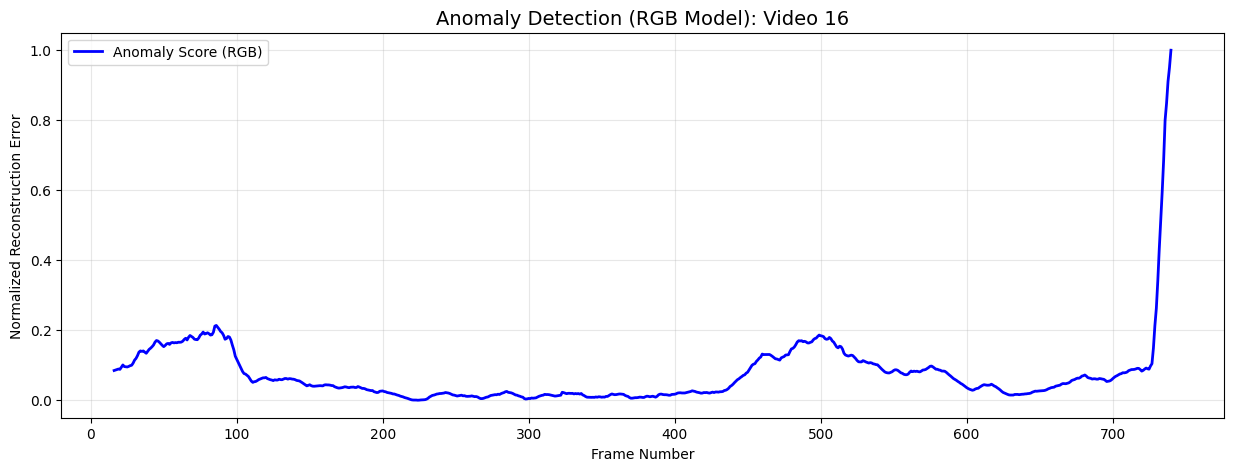

In [11]:
import os
import glob
import random
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

# ================= CONFIGURATION =================
# 1. Path to CLEANED TEST VIDEOS (from Step 1)
CLEAN_TEST_DIR = '/kaggle/working/denoised_dataset_test'

# 2. Path to Trained RGB Model
MODEL_PATH = 'st_autoencoder_rgb.pth'

CLIP_LEN = 16
IMG_SIZE = 128
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# =================================================

# --- 1. Model Architecture (Must match training) ---
class STAutoEncoder_Full(nn.Module):
    def __init__(self, in_channels=3): 
        super(STAutoEncoder_Full, self).__init__()
        self.conv1 = nn.Conv3d(in_channels, 32, 3, padding=1); self.bn1 = nn.BatchNorm3d(32); self.pool1 = nn.MaxPool3d(2, 2)
        self.conv2 = nn.Conv3d(32, 48, 3, padding=1); self.bn2 = nn.BatchNorm3d(48); self.pool2 = nn.MaxPool3d(2, 2)
        self.conv3 = nn.Conv3d(48, 64, 3, padding=1); self.bn3 = nn.BatchNorm3d(64); self.pool3 = nn.MaxPool3d(2, 2)
        self.conv4 = nn.Conv3d(64, 64, 3, padding=1); self.bn4 = nn.BatchNorm3d(64); self.relu = nn.LeakyReLU(0.1)
        
        self.rec_deconv1 = nn.ConvTranspose3d(64, 48, 3, 2, 1, 1); self.rec_bn1 = nn.BatchNorm3d(48)
        self.rec_deconv2 = nn.ConvTranspose3d(48, 32, 3, 2, 1, 1); self.rec_bn2 = nn.BatchNorm3d(32)
        self.rec_deconv3 = nn.ConvTranspose3d(32, 32, 3, 2, 1, 1); self.rec_bn3 = nn.BatchNorm3d(32)
        self.rec_final = nn.Conv3d(32, in_channels, 3, padding=1)
        
        self.pred_deconv1 = nn.ConvTranspose3d(64, 48, 3, 2, 1, 1); self.pred_bn1 = nn.BatchNorm3d(48)
        self.pred_deconv2 = nn.ConvTranspose3d(48, 32, 3, 2, 1, 1); self.pred_bn2 = nn.BatchNorm3d(32)
        self.pred_deconv3 = nn.ConvTranspose3d(32, 32, 3, 2, 1, 1); self.pred_bn3 = nn.BatchNorm3d(32)
        self.pred_final = nn.Conv3d(32, in_channels, 3, padding=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        l = self.relu(self.bn4(self.conv4(self.pool3(self.relu(self.bn3(self.conv3(self.pool2(self.relu(self.bn2(self.conv2(self.pool1(self.relu(self.bn1(self.conv1(x)))))))))))))))
        r = self.sigmoid(self.rec_final(self.relu(self.rec_bn3(self.rec_deconv3(self.relu(self.rec_bn2(self.rec_deconv2(self.relu(self.rec_bn1(self.rec_deconv1(l)))))))))))
        p = self.sigmoid(self.pred_final(self.relu(self.pred_bn3(self.pred_deconv3(self.relu(self.pred_bn2(self.pred_deconv2(self.relu(self.pred_bn1(self.pred_deconv1(l)))))))))))
        return r, p

def visualize_rgb_anomaly():
    print("Preparing RGB Visualization...")
    
    # 1. Pick a Random Video
    video_folders = sorted([f for f in os.listdir(CLEAN_TEST_DIR) if os.path.isdir(os.path.join(CLEAN_TEST_DIR, f))])
    if not video_folders:
        print("No video folders found! Did you run the cleaner?")
        return
        
    random_vid_id = random.choice(video_folders)
    print(f"Selected Video: {random_vid_id}")
    
    vid_path = os.path.join(CLEAN_TEST_DIR, random_vid_id)
    frames = sorted(glob.glob(os.path.join(vid_path, '*.jpg')))
    
    if len(frames) < CLIP_LEN:
        print("Video too short!")
        return

    # 2. Load Model
    model = STAutoEncoder_Full(in_channels=3)
    
    # Load weights
    if not os.path.exists(MODEL_PATH):
        print(f"Model file {MODEL_PATH} not found!")
        return
        
    state_dict = torch.load(MODEL_PATH, map_location=DEVICE)
    new_state_dict = {}
    for k, v in state_dict.items():
        if k.startswith('module.'): new_state_dict[k[7:]] = v
        else: new_state_dict[k] = v
    model.load_state_dict(new_state_dict)
    model.to(DEVICE)
    model.eval()
    
    # 3. Process Video
    transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
    ])
    
    scores = []
    frame_indices = []
    mse_loss = nn.MSELoss(reduction='none')
    
    print(f"Processing {len(frames)} frames...")
    
    with torch.no_grad():
        # Slide through video
        for i in range(len(frames) - CLIP_LEN + 1):
            clip_paths = frames[i : i + CLIP_LEN]
            
            # Load RGB frames
            volume = [transform(Image.open(p).convert('RGB')) for p in clip_paths]
            
            # Stack: (1, 3, 16, 128, 128)
            input_tensor = torch.stack(volume, dim=0).permute(1, 0, 2, 3).unsqueeze(0).to(DEVICE)
            
            # Inference
            rec_out, _ = model(input_tensor)
            
            # Calculate Error
            loss = mse_loss(rec_out, input_tensor)
            error_val = torch.sum(loss).item()
            
            scores.append(error_val)
            # Map score to the last frame of the clip
            frame_indices.append(i + CLIP_LEN)

    # 4. Plot
    scores = np.array(scores)
    
    # Normalize scores 0-1 for plotting
    if scores.max() > scores.min():
        scores_norm = (scores - scores.min()) / (scores.max() - scores.min())
    else:
        scores_norm = scores
        
    plt.figure(figsize=(15, 5))
    plt.plot(frame_indices, scores_norm, color='blue', linewidth=2, label='Anomaly Score (RGB)')
    plt.title(f"Anomaly Detection (RGB Model): Video {random_vid_id}", fontsize=14)
    plt.xlabel("Frame Number")
    plt.ylabel("Normalized Reconstruction Error")
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    save_path = f"rgb_anomaly_plot_{random_vid_id}.png"
    plt.savefig(save_path)
    print(f"Plot saved to {save_path}")
    plt.show()

if __name__ == "__main__":
    visualize_rgb_anomaly()

## Submission script generation

In [8]:
import os
import glob
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm import tqdm

# ================= CONFIGURATION =================
# 1. Path to CLEANED TEST VIDEOS (from Step 1: RotNet Cleaner)
# This MUST be the un-flipped version
CLEAN_TEST_DIR = '/kaggle/working/denoised_dataset_test' 

# 2. Path to your Trained RGB Model
MODEL_PATH = 'st_autoencoder_rgb.pth'

# 3. Output Filename
OUTPUT_CSV = 'submission.csv'

CLIP_LEN = 16
IMG_SIZE = 128
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# =================================================

# --- 1. Model Architecture (Must match training exactly) ---
class STAutoEncoder_Full(nn.Module):
    def __init__(self, in_channels=3): 
        super(STAutoEncoder_Full, self).__init__()
        self.conv1 = nn.Conv3d(in_channels, 32, 3, padding=1); self.bn1 = nn.BatchNorm3d(32); self.pool1 = nn.MaxPool3d(2, 2)
        self.conv2 = nn.Conv3d(32, 48, 3, padding=1); self.bn2 = nn.BatchNorm3d(48); self.pool2 = nn.MaxPool3d(2, 2)
        self.conv3 = nn.Conv3d(48, 64, 3, padding=1); self.bn3 = nn.BatchNorm3d(64); self.pool3 = nn.MaxPool3d(2, 2)
        self.conv4 = nn.Conv3d(64, 64, 3, padding=1); self.bn4 = nn.BatchNorm3d(64); self.relu = nn.LeakyReLU(0.1)
        
        self.rec_deconv1 = nn.ConvTranspose3d(64, 48, 3, 2, 1, 1); self.rec_bn1 = nn.BatchNorm3d(48)
        self.rec_deconv2 = nn.ConvTranspose3d(48, 32, 3, 2, 1, 1); self.rec_bn2 = nn.BatchNorm3d(32)
        self.rec_deconv3 = nn.ConvTranspose3d(32, 32, 3, 2, 1, 1); self.rec_bn3 = nn.BatchNorm3d(32)
        self.rec_final = nn.Conv3d(32, in_channels, 3, padding=1)
        
        self.pred_deconv1 = nn.ConvTranspose3d(64, 48, 3, 2, 1, 1); self.pred_bn1 = nn.BatchNorm3d(48)
        self.pred_deconv2 = nn.ConvTranspose3d(48, 32, 3, 2, 1, 1); self.pred_bn2 = nn.BatchNorm3d(32)
        self.pred_deconv3 = nn.ConvTranspose3d(32, 32, 3, 2, 1, 1); self.pred_bn3 = nn.BatchNorm3d(32)
        self.pred_final = nn.Conv3d(32, in_channels, 3, padding=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        l = self.relu(self.bn4(self.conv4(self.pool3(self.relu(self.bn3(self.conv3(self.pool2(self.relu(self.bn2(self.conv2(self.pool1(self.relu(self.bn1(self.conv1(x)))))))))))))))
        r = self.sigmoid(self.rec_final(self.relu(self.rec_bn3(self.rec_deconv3(self.relu(self.rec_bn2(self.rec_deconv2(self.relu(self.rec_bn1(self.rec_deconv1(l)))))))))))
        p = self.sigmoid(self.pred_final(self.relu(self.pred_bn3(self.pred_deconv3(self.relu(self.pred_bn2(self.pred_deconv2(self.relu(self.pred_bn1(self.pred_deconv1(l)))))))))))
        return r, p

# --- 2. Dataset for Inference ---
class TestRGBDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform
        
        # Scan Cleaned Directory
        video_folders = sorted(os.listdir(root_dir))
        for vid in video_folders:
            v_path = os.path.join(root_dir, vid)
            if not os.path.isdir(v_path): continue
            
            frames = sorted(glob.glob(os.path.join(v_path, '*.jpg')))
            
            # Sliding Window of 1
            for i in range(len(frames) - CLIP_LEN + 1):
                clip = frames[i : i + CLIP_LEN]
                
                # Target is the LAST frame of the clip
                # Parse ID from filename: "frame_0016.jpg" -> 16
                target_fname = os.path.basename(clip[-1])
                f_num = int(target_fname.split('_')[-1].split('.')[0])
                target_id = f"{int(vid)}_{f_num}"
                
                self.samples.append((clip, target_id))

    def __len__(self): return len(self.samples)

    def __getitem__(self, idx):
        clip, row_id = self.samples[idx]
        # Load Volume
        vol = [self.transform(Image.open(p).convert('RGB')) for p in clip]
        # Stack: (16, 3, H, W) -> (3, 16, H, W)
        return torch.stack(vol, dim=0).permute(1, 0, 2, 3), row_id

def generate_rgb_submission():
    print(f"Generating Submission on {DEVICE}")
    
    # 1. Create Master List of ALL IDs (Safety Net)
    # This ensures we don't miss frames 1-15 which the model skips
    print("Scanning for all expected frames...")
    all_expected_ids = []
    for vid in sorted(os.listdir(CLEAN_TEST_DIR)):
        v_path = os.path.join(CLEAN_TEST_DIR, vid)
        if not os.path.isdir(v_path): continue
        for f in glob.glob(os.path.join(v_path, '*.jpg')):
            try:
                vid_id = int(vid)
                f_num = int(os.path.basename(f).split('_')[-1].split('.')[0])
                all_expected_ids.append(f"{vid_id}_{f_num}")
            except: pass
    master_df = pd.DataFrame(all_expected_ids, columns=['Id'])
    print(f"Total frames expected: {len(master_df)}")

    # 2. Setup Inference
    transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor()
    ])
    
    dataset = TestRGBDataset(CLEAN_TEST_DIR, transform=transform)
    loader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=2)
    
    # 3. Load Model
    model = STAutoEncoder_Full(in_channels=3).to(DEVICE)
    
    if os.path.exists(MODEL_PATH):
        state_dict = torch.load(MODEL_PATH, map_location=DEVICE)
        new_state_dict = {}
        for k, v in state_dict.items():
            if k.startswith('module.'): new_state_dict[k[7:]] = v
            else: new_state_dict[k] = v
        model.load_state_dict(new_state_dict)
    else:
        print(f"ERROR: Model {MODEL_PATH} not found!")
        return

    model.eval()
    mse = nn.MSELoss(reduction='none')
    results = []

    print("Running Inference...")
    with torch.no_grad():
        for volume, row_id in tqdm(loader):
            volume = volume.to(DEVICE)
            
            # Forward Pass
            rec_out, _ = model(volume)
            
            # Calculate Reconstruction Error
            loss = mse(rec_out, volume)
            score = torch.sum(loss).item() # Sum error over all pixels/channels/frames
            
            results.append({'Id': row_id[0], 'Score': score})
            
    # 4. Post-Processing
    results_df = pd.DataFrame(results)
    
    # Merge with Master List (Left Join)
    final_df = pd.merge(master_df, results_df, on='Id', how='left')
    
    # Fill Missing Scores (Frames 1-15) with Minimum (Normal)
    min_score = final_df['Score'].min()
    if pd.isna(min_score): min_score = 0
    final_df['Score'] = final_df['Score'].fillna(min_score)
    
    # Normalize Scores [0, 1]
    max_score = final_df['Score'].max()
    final_df['Predicted'] = (final_df['Score'] - min_score) / (max_score - min_score)
    
    # Sort by Video ID then Frame ID
    final_df[['vid', 'frame']] = final_df['Id'].str.split('_', expand=True).astype(int)
    final_df = final_df.sort_values(by=['vid', 'frame']).drop(columns=['vid', 'frame'])
    
    # Save
    final_df[['Id', 'Predicted']].to_csv(OUTPUT_CSV, index=False)
    print(f"\nSUCCESS! Submission saved to {OUTPUT_CSV}")
    print(final_df.head(20))

if __name__ == "__main__":
    generate_rgb_submission()

Generating Submission on cuda
Scanning for all expected frames...
Total frames expected: 11706
Running Inference...


100%|██████████| 11391/11391 [05:51<00:00, 32.40it/s]



SUCCESS! Submission saved to submission.csv
       Id         Score  Predicted
395   1_0    517.334778   0.000000
60    1_1    517.334778   0.000000
411   1_2    517.334778   0.000000
376   1_3    517.334778   0.000000
464   1_4    517.334778   0.000000
363   1_5    517.334778   0.000000
146   1_6    517.334778   0.000000
463   1_7    517.334778   0.000000
281   1_8    517.334778   0.000000
264   1_9    517.334778   0.000000
459  1_10    517.334778   0.000000
357  1_11    517.334778   0.000000
446  1_12    517.334778   0.000000
315  1_13    517.334778   0.000000
175  1_14    517.334778   0.000000
194  1_15   9796.502930   0.944496
269  1_16   9754.465820   0.940218
160  1_17   9885.048828   0.953509
341  1_18   9990.406250   0.964233
116  1_19  10129.277344   0.978369


## Post-Processing

Sigmoid Normalising (good for visualisation)

📂 Loading /kaggle/working/submission.csv...
⚡ Applying Sigmoid (Center=0.1, Steepness=15)...
📸 Saved visualization to 'score_distribution_u_graph.png'


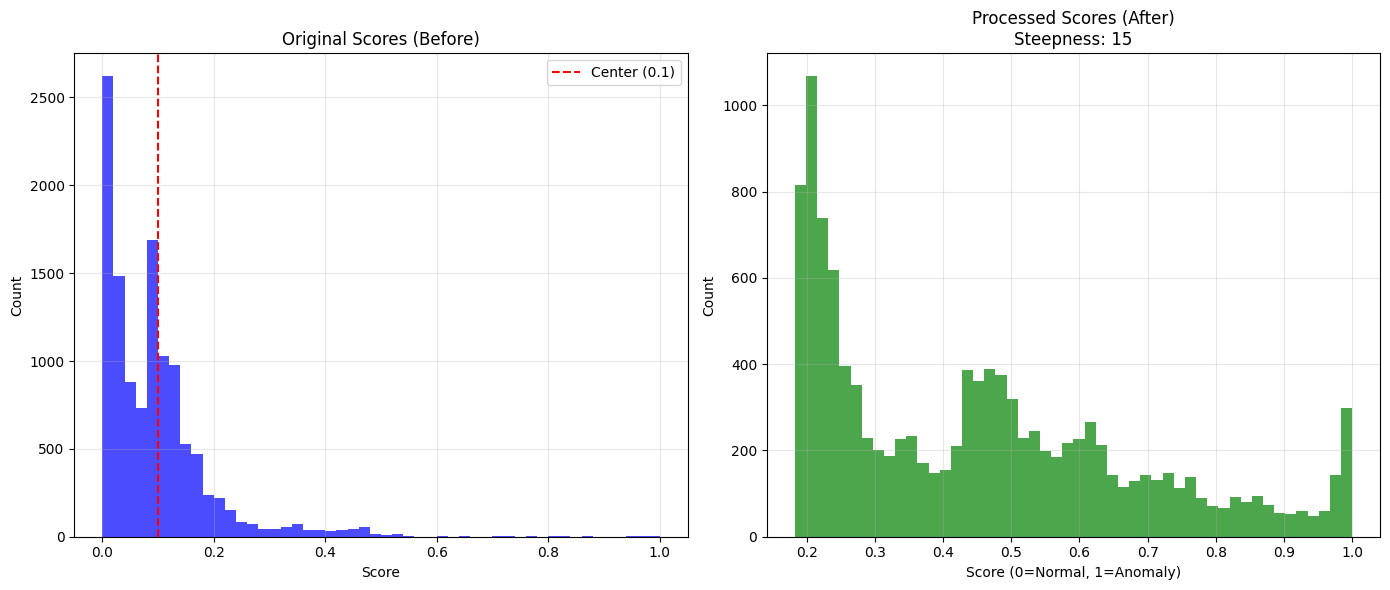

✅ Saved processed scores to submission_processed.csv
    Id  Predicted
0  1_0   0.182426
1  1_1   0.182426
2  1_2   0.182426
3  1_3   0.182426
4  1_4   0.182426


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ================= CONFIGURATION =================
INPUT_CSV = '/kaggle/working/submission.csv'
OUTPUT_CSV = 'submission_processed.csv'

# The "Center" of your sigmoid (The threshold between Normal vs Anomaly)
# You observed normals are < 0.1, so 0.1 is the tipping point.
CENTER = 0.1

# How hard to push values to 0 and 1.
# Low (e.g. 10) = Gentle S-curve
# High (e.g. 50) = Hard Step Function (Almost binary)
STEEPNESS = 15
# =================================================

def sigmoid_transform(x, center, k):
    """
    Custom Sigmoid:
    x: Input score array
    center: The value that maps to 0.5 (tipping point)
    k: Steepness coefficient
    """
    # 1. Shift x so the center is at 0
    shifted = x - center
    
    # 2. Scale by steepness
    scaled = k * shifted
    
    # 3. Apply standard sigmoid: 1 / (1 + e^-x)
    return 1 / (1 + np.exp(-scaled))

def process_and_visualize():
    print(f"📂 Loading {INPUT_CSV}...")
    df = pd.read_csv(INPUT_CSV)
    
    original_scores = df['Predicted'].values
    
    # --- APPLY TRANSFORM ---
    print(f"⚡ Applying Sigmoid (Center={CENTER}, Steepness={STEEPNESS})...")
    new_scores = sigmoid_transform(original_scores, CENTER, STEEPNESS)
    
    df['Predicted'] = new_scores
    
    # --- VISUALIZATION (THE "U" GRAPH) ---
    plt.figure(figsize=(14, 6))
    
    # Plot 1: Original Distribution
    plt.subplot(1, 2, 1)
    plt.hist(original_scores, bins=50, color='blue', alpha=0.7)
    plt.axvline(CENTER, color='red', linestyle='--', label=f'Center ({CENTER})')
    plt.title("Original Scores (Before)")
    plt.xlabel("Score")
    plt.ylabel("Count")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Processed Distribution (Should look like a U)
    plt.subplot(1, 2, 2)
    plt.hist(new_scores, bins=50, color='green', alpha=0.7)
    plt.title(f"Processed Scores (After)\nSteepness: {STEEPNESS}")
    plt.xlabel("Score (0=Normal, 1=Anomaly)")
    plt.ylabel("Count")
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig("score_distribution_u_graph.png")
    print("📸 Saved visualization to 'score_distribution_u_graph.png'")
    plt.show()
    
    # --- SAVE ---
    df.to_csv(OUTPUT_CSV, index=False)
    print(f"✅ Saved processed scores to {OUTPUT_CSV}")
    print(df.head())

if __name__ == "__main__":
    process_and_visualize()

Anomaly window detection (smoothning)

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ================= CONFIGURATION =================
# Use the file that gave you 0.66
INPUT_CSV = '/kaggle/working/submission_processed.csv' 
OUTPUT_CSV = 'submission_boosted_STAE_rgb.csv'

# DILATION WINDOW
# Avenue is 25fps. Events last ~1-2 seconds.
# A window of 25 means we look +/- 12 frames around a peak.
WINDOW_SIZE = 20
# =================================================

def boost_score():
    print(f"Reading {INPUT_CSV}...")
    df = pd.read_csv(INPUT_CSV)
    
    df['VideoID'] = df['Id'].apply(lambda x: x.split('_')[0])
    
    final_preds = []
    
    print(f"Applying Peak Widening (Window={WINDOW_SIZE})...")
    
    for vid, group in df.groupby('VideoID', sort=False):
        raw = group['Predicted'].copy()
        
        # 1. ROLLING MAX (Dilation)
        # This spreads the '1.0' scores to their neighbors.
        # "If frame T is bad, then frame T+1 is probably bad too."
        dilated = raw.rolling(window=WINDOW_SIZE, center=True, min_periods=1).max()
        
        # 2. LIGHT SMOOTHING (Average)
        # Rolling max creates "blocky" steps. We smooth the edges slightly.
        smoothed = dilated.rolling(window=10, center=True, min_periods=1).mean()
        
        
        
        final_preds.extend(smoothed.values)
        
    df['Predicted'] = final_preds
    
    # Final Normalize (Safety)
    df['Predicted'] = np.clip(df['Predicted'], 0.0, 1.0)
    
    # --- VISUALIZATION ---
    # Let's see how much "fatter" the detection became
    v05 = df[df['Id'].str.startswith('05_')]
    if not v05.empty:
        x = v05['Id'].apply(lambda x: int(x.split('_')[1]))
        plt.figure(figsize=(15, 5))
        
        # We need to reload original to compare
        orig = pd.read_csv(INPUT_CSV)
        orig_v05 = orig[orig['Id'].str.startswith('05_')]
        
        plt.plot(x, orig_v05['Predicted'], color='gray', alpha=0.5, label='Original (0.66)')
        plt.plot(x, v05['Predicted'], color='green', linewidth=2, label='Widened (Boosted)')
        
        plt.title("Peak Widening Effect (Video 05)")
        plt.legend()
        plt.show()

    # Save
    out = df[['Id', 'Predicted']]
    out.to_csv(OUTPUT_CSV, index=False)
    print(f"Saved boosted scores to {OUTPUT_CSV}")

if __name__ == "__main__":
    boost_score()

Reading /kaggle/working/submission_processed.csv...
Applying Peak Widening (Window=20)...
Saved boosted scores to submission_boosted_STAE_rgb.csv


This output is used in final essemble code.

## Final visualiser

📂 Loading /kaggle/working/submission_boosted_STAE_rgb.csv...
🔄 Parsing data...
🌍 Visualizing 21 videos...
------------------------------


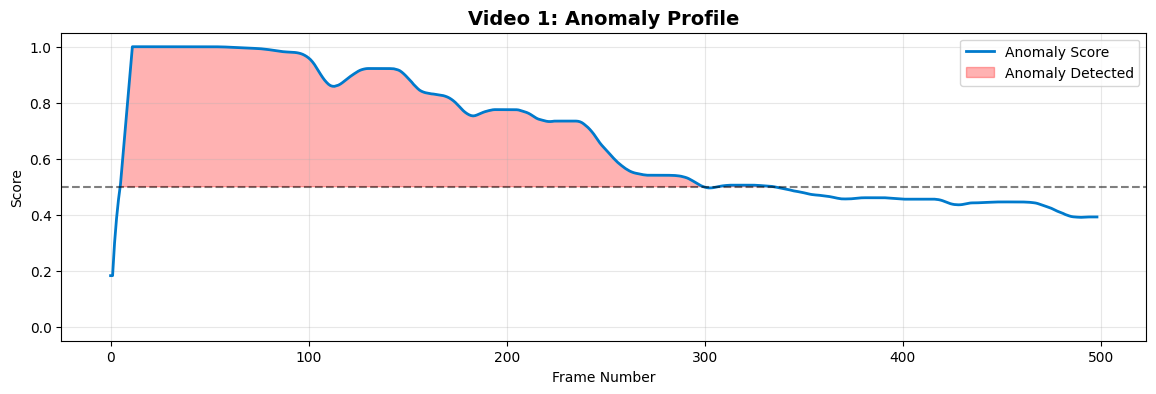

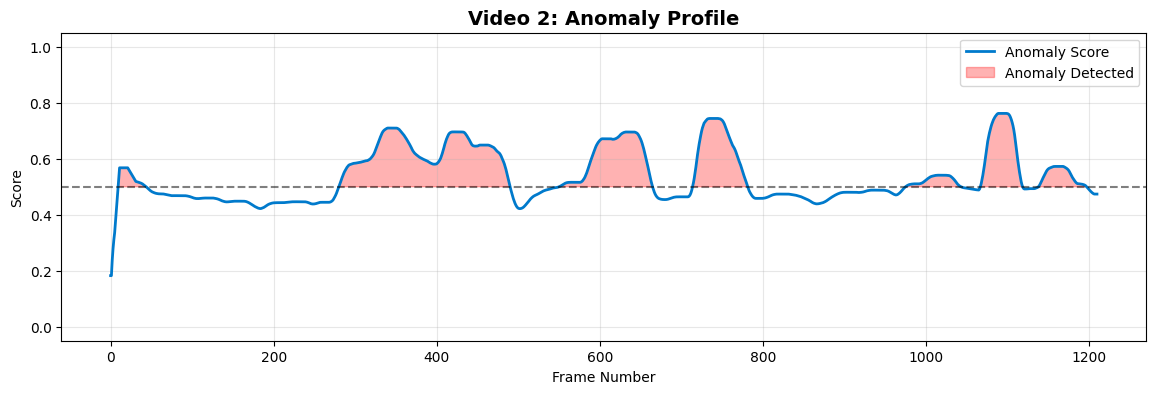

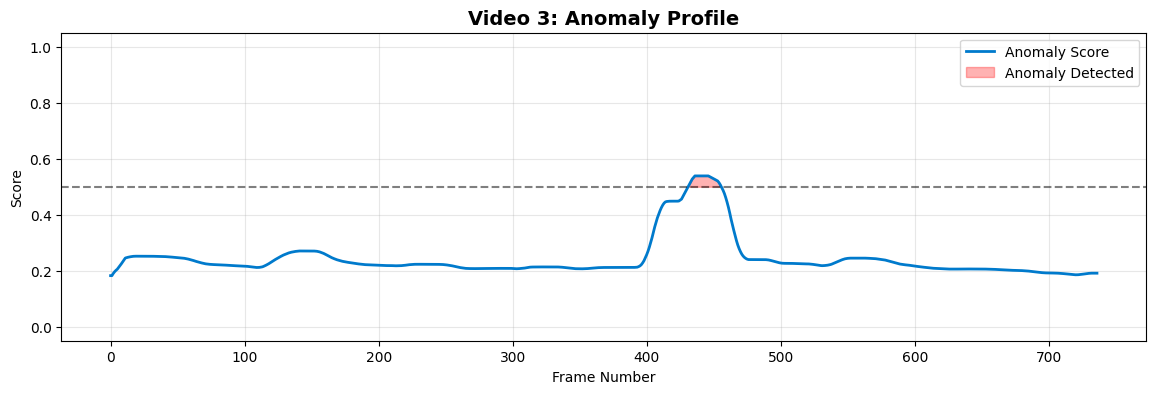

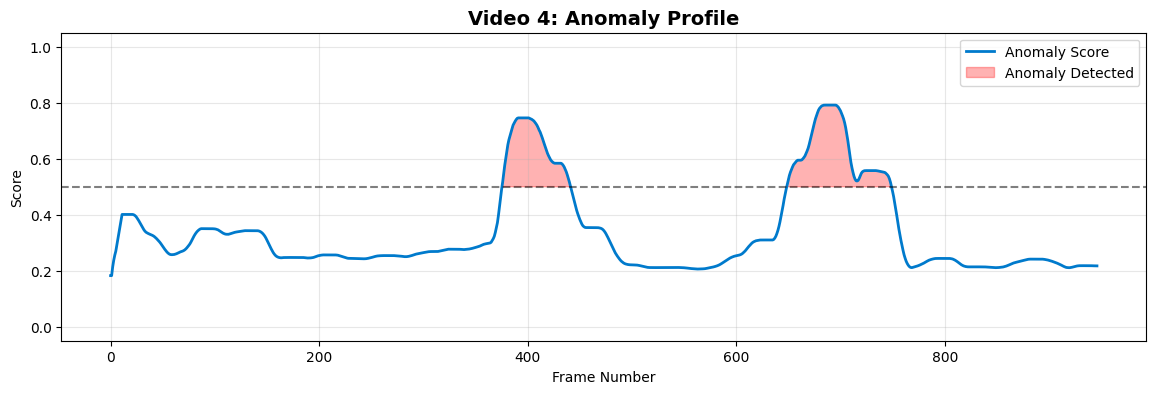

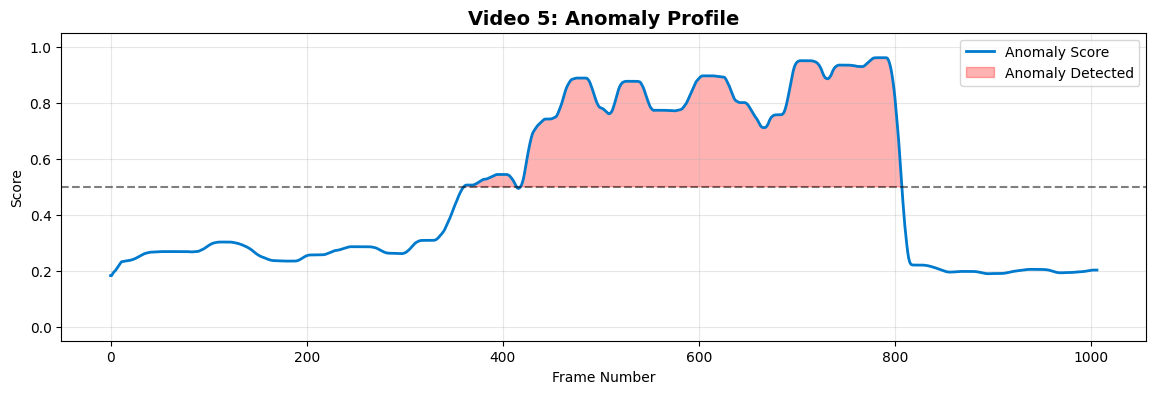

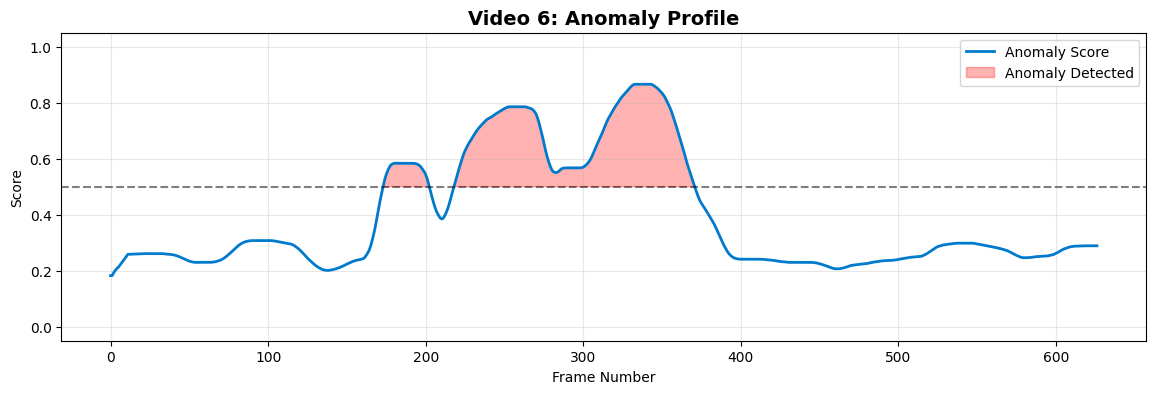

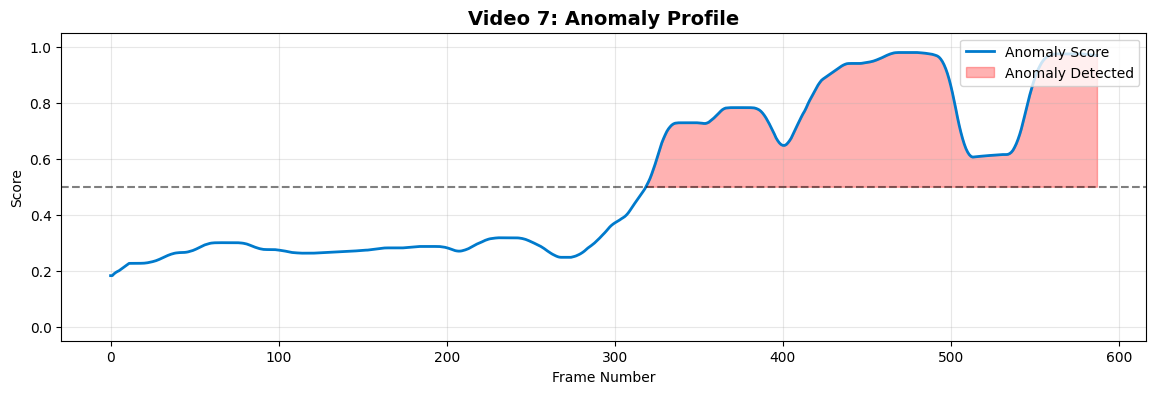

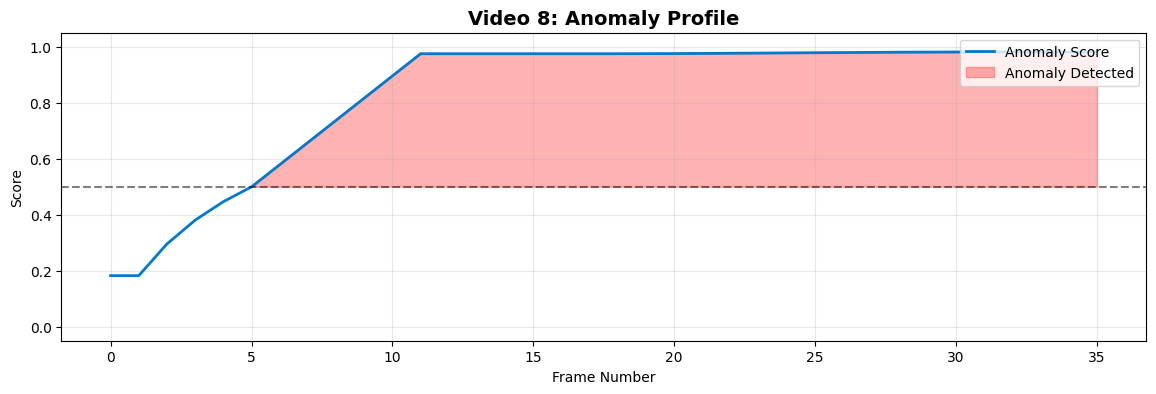

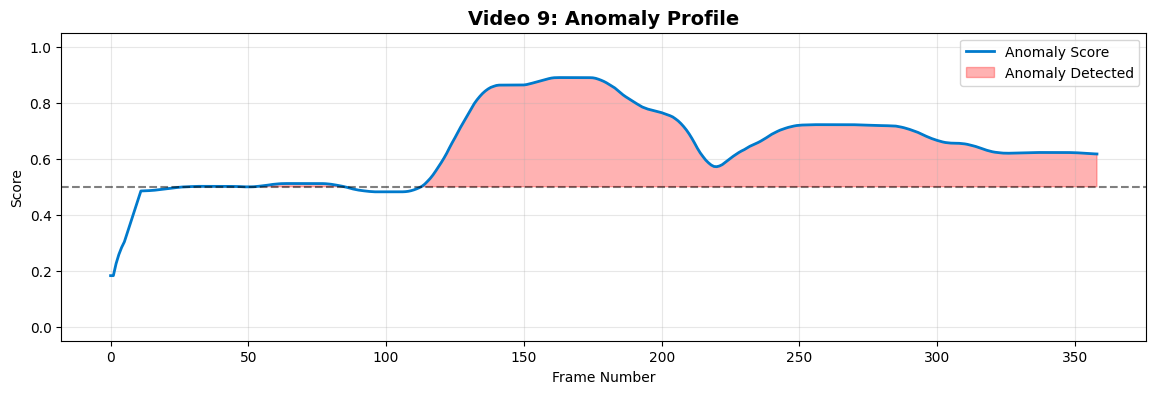

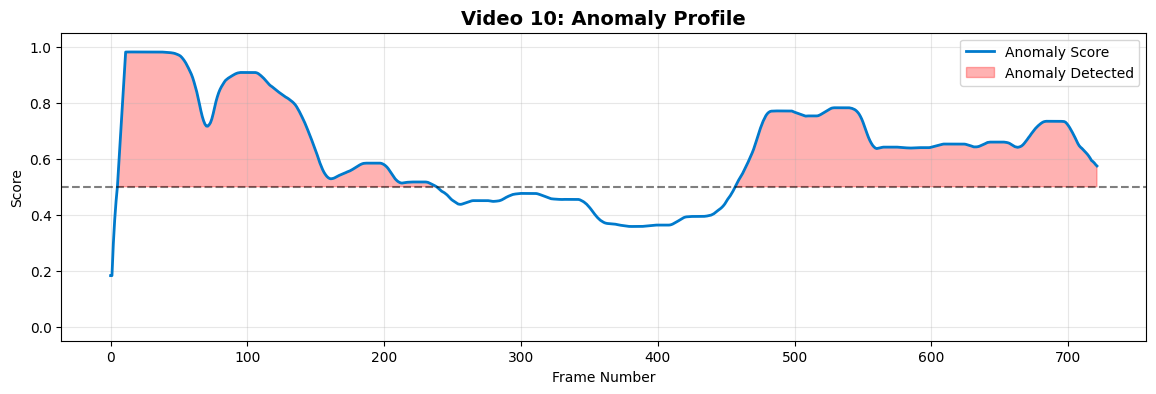

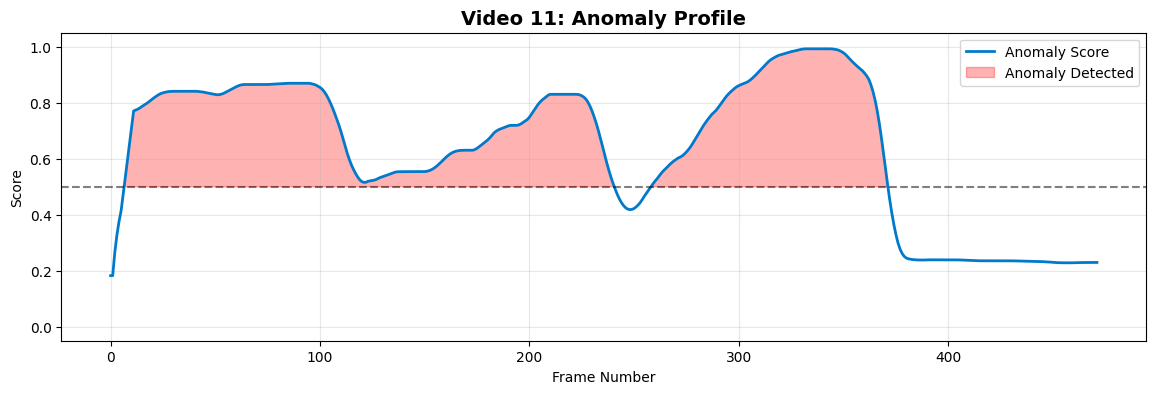

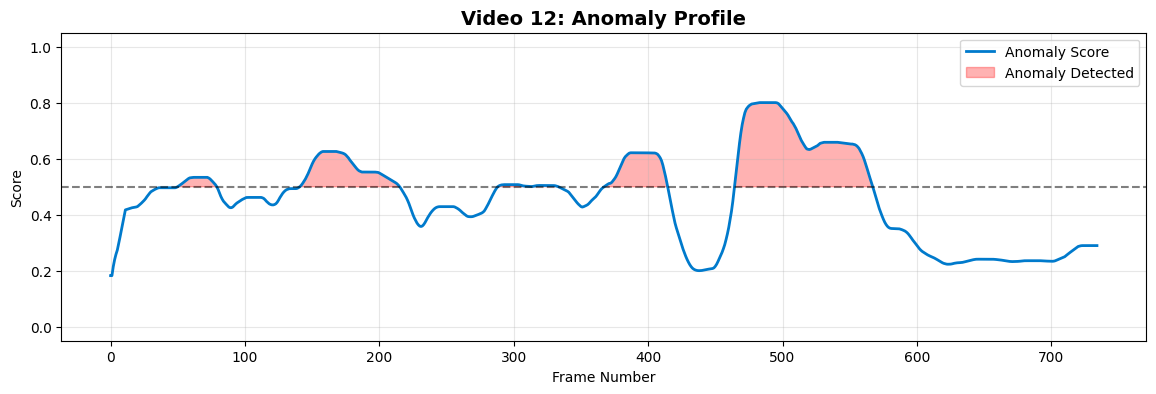

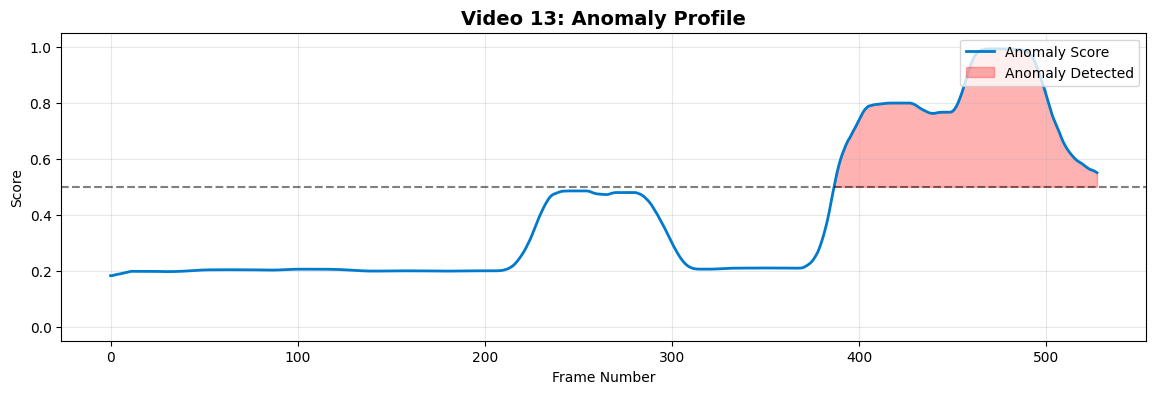

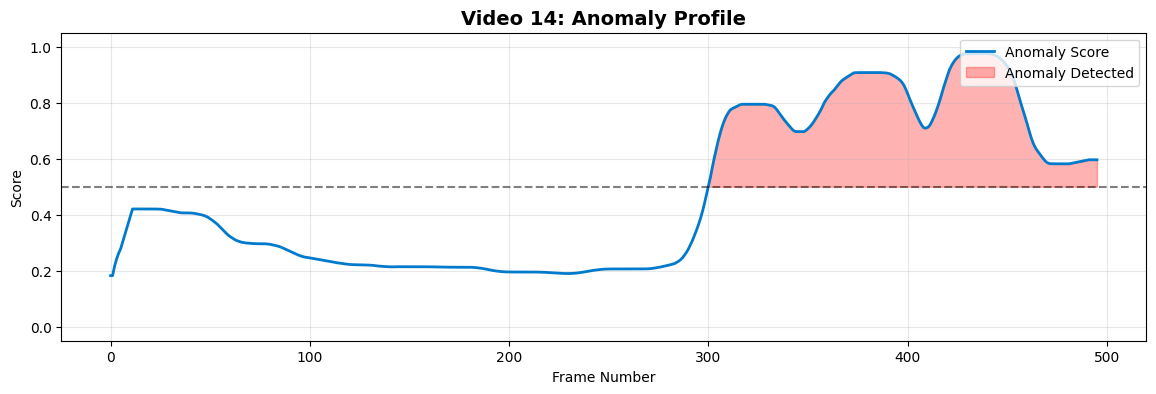

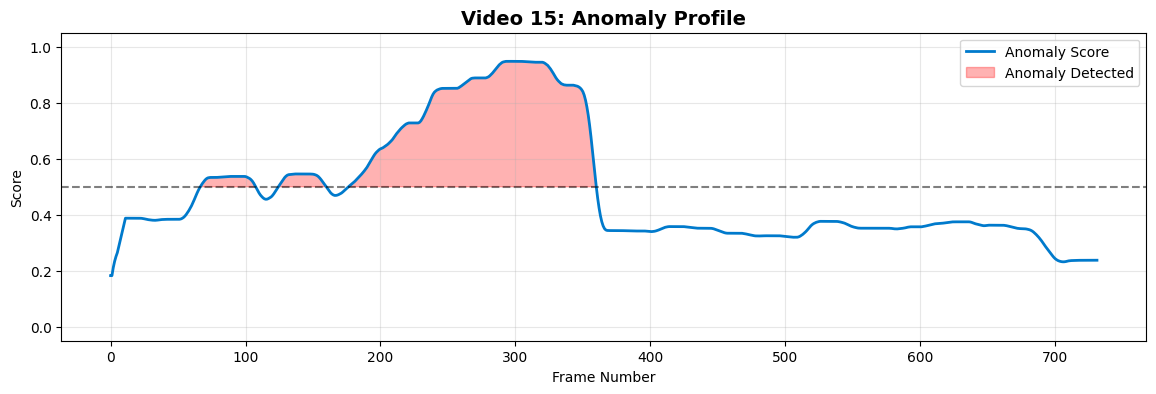

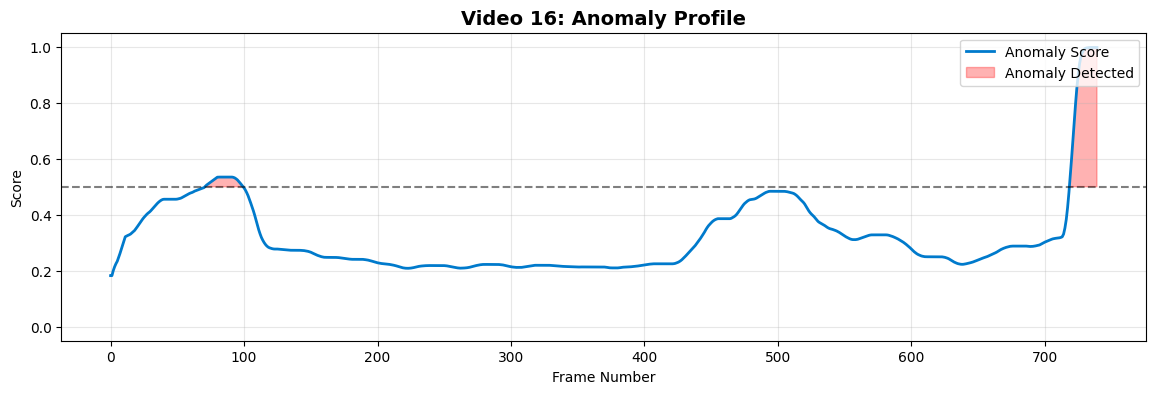

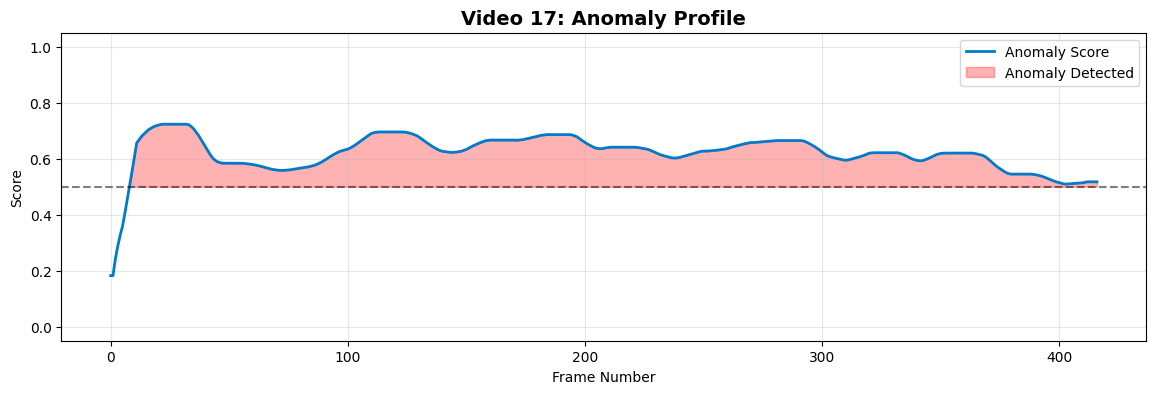

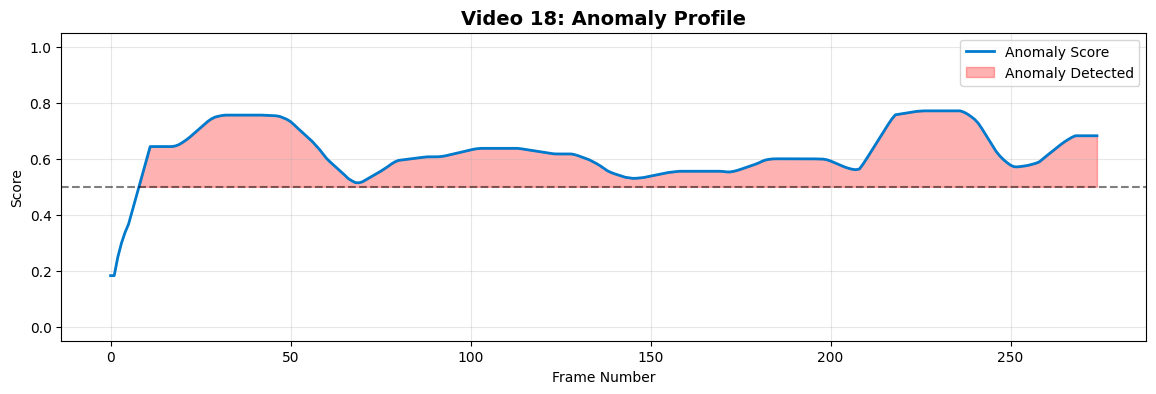

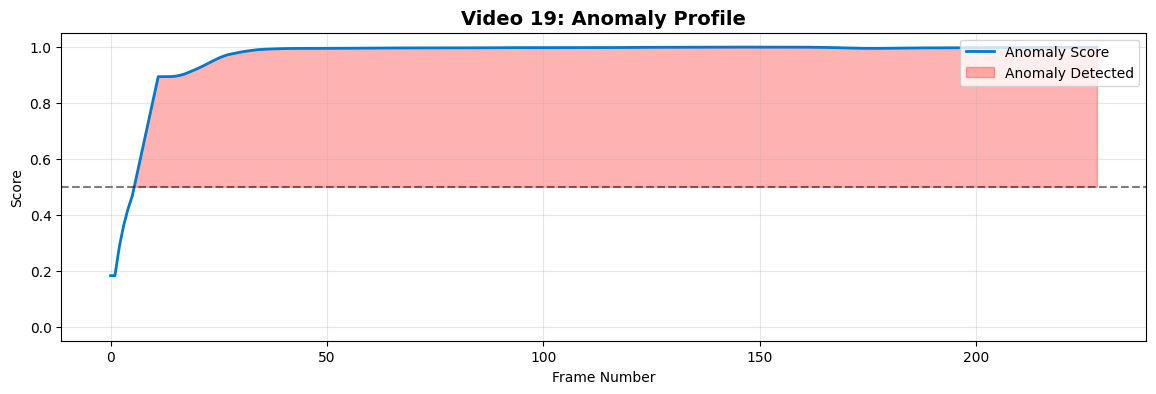

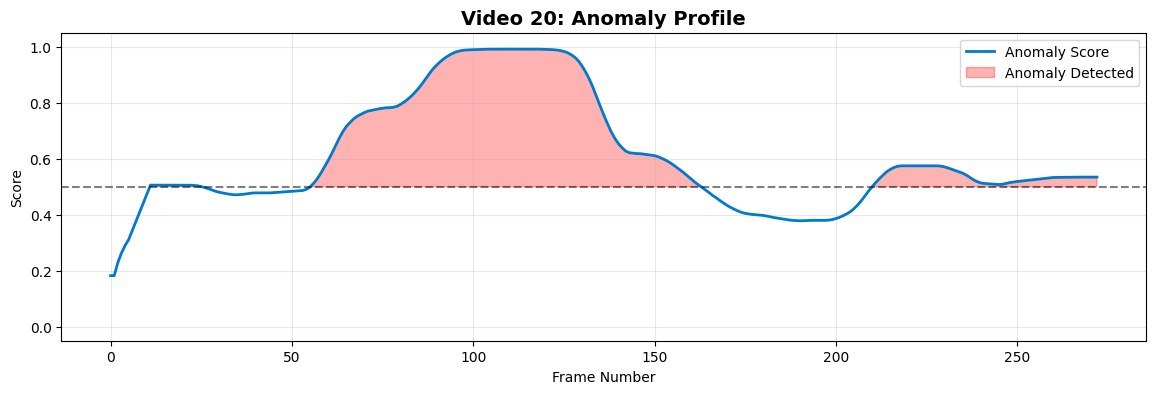

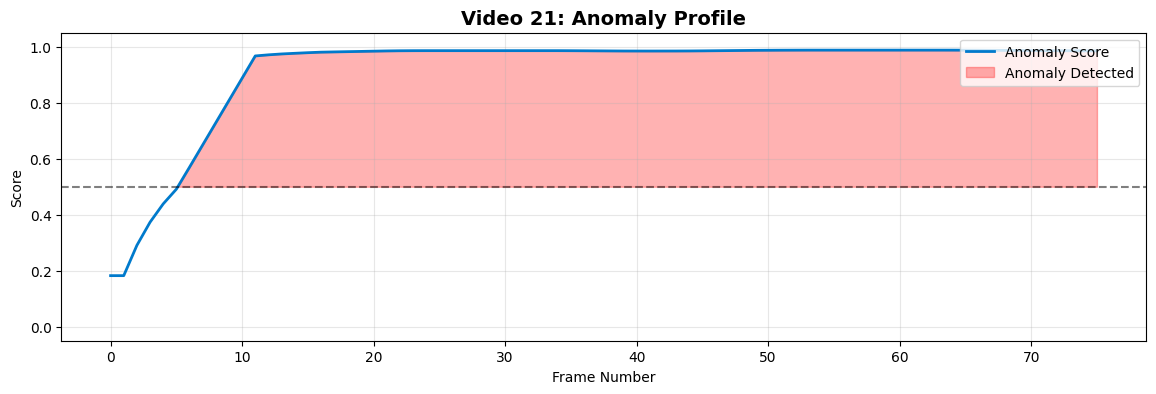

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ================= CONFIGURATION =================
INPUT_CSV = '/kaggle/working/submission_boosted_STAE_rgb.csv'
THRESHOLD = 0.5 
# =================================================

def visualize_inline():
    print(f"📂 Loading {INPUT_CSV}...")
    try:
        df = pd.read_csv(INPUT_CSV)
    except FileNotFoundError:
        print("❌ Error: File not found. Did you run the previous step?")
        return

    # 1. Parse 'ID' (e.g., '1_939') back into Video and Frame columns
    print("🔄 Parsing data...")
    split_data = df['Id'].str.split('_', expand=True)
    df['video_id'] = split_data[0].astype(int)
    df['frame_id'] = split_data[1].astype(int)
    
    # 2. Get unique videos
    videos = sorted(df['video_id'].unique())
    print(f"🌍 Visualizing {len(videos)} videos...")
    print("-" * 30)

    # 3. Loop and Plot Inline
    for vid in videos:
        # Filter data for this video
        vid_df = df[df['video_id'] == vid].sort_values(by='frame_id')
        
        frames = vid_df['frame_id'].values
        scores = vid_df['Predicted'].values
        
        # Create Plot
        plt.figure(figsize=(14, 4)) # Wide and short for better scrolling
        
        # Plot the Score Line
        plt.plot(frames, scores, color='#007acc', linewidth=2, label='Anomaly Score')
        
        # Fill area under curve for anomalies (Red Zones)
        plt.fill_between(frames, scores, THRESHOLD, where=(scores >= THRESHOLD), 
                         interpolate=True, color='red', alpha=0.3, label='Anomaly Detected')
        
        # Add Threshold Line
        plt.axhline(y=THRESHOLD, color='black', linestyle='--', alpha=0.5)
        
        # Styling
        plt.title(f"Video {vid}: Anomaly Profile", fontsize=14, fontweight='bold')
        plt.xlabel("Frame Number")
        plt.ylabel("Score")
        plt.ylim(-0.05, 1.05)
        plt.grid(True, alpha=0.3)
        plt.legend(loc='upper right')
        
        # SHOW PLOT
        plt.show()
        print("\n") # Spacing

if __name__ == "__main__":
    visualize_inline()